<a href="https://colab.research.google.com/github/grace3999/USV_Python/blob/colab/Notebooks/4_xr_Annotations_classification_8features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#mount google drive containings required files: 1) csv of annotation features, 2) netcdf files
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install netcdf4

In [3]:
!pip install seaborn==0.9.0

In [0]:
import numpy as np
import pandas as pd
import xarray as xr
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, cross_val_predict, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score
from sklearn.utils import resample

#visualizing results
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

In [0]:
features_path_CPA = '/content/gdrive/Shared drives/USV_eScience_Incubator/Data/feature_data_frames/annot_8features_100noise_CPA.csv'
features_path_neutral = '/content/gdrive/Shared drives/USV_eScience_Incubator/Data/feature_data_frames/annot_8features_100noise_neutral.csv'
features_path = [features_path_CPA, features_path_neutral]

In [6]:
annot_features_df = pd.DataFrame()

#Read in data frame of annotation features
for path in features_path:
  data = pd.read_csv(path)
  annot_features = pd.DataFrame(data = data)
  print(annot_features.shape)
  #check for missing values
  if annot_features.isnull().sum().sum() > 0:
    print('You have missing values in your data frame')
  else:
    print('Your data frame is complete')
  
  annot_features_df = annot_features_df.append(annot_features)

annot_features_df.replace('low ', 'low', inplace=True)
annot_features_df.replace('BBC', 'bbc', inplace=True)
print(annot_features_df.shape)
annot_features_df.head()

(2925, 13)
Your data frame is complete
(1803, 13)
You have missing values in your data frame
(4728, 13)


,Unnamed: 0,animal_number,session,time_stamp,Annotation,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll
0,0,625,CPApost,370080.0,bbc,790363.2,0.035429,15183.269143,14384.634481,3.481302,13.177353,-0.001636,14424.105686
1,1,625,CPApost,548797.5,bbc,759710.3,0.031698,10559.432571,23123.280511,6.019992,37.846796,-0.001350,10031.460942
2,2,622,CPApost,67095.0,bbc,1245231.9,0.023606,16095.489676,16262.169980,3.540321,13.160911,-0.001582,15290.715192
3,3,622,CPApost,67702.5,bbc,671757.5,0.034147,10680.253669,20551.780884,5.519050,31.630580,-0.001356,10146.240986
4,4,622,CPApost,67972.5,bbc,1741314.6,0.022195,16826.942890,13543.086338,4.088031,20.161623,-0.001636,15985.595745


In [7]:
annot_features_df.dropna(axis=0, inplace=True)
annot_features_df['Annotation'].value_counts()

rand_noise     4298
low             162
bbc             140
low multi        50
high             48
low complex      23
high multi        5
Name: Annotation, dtype: int64

In [8]:
annot_features_df.groupby('Annotation').mean()

,Unnamed: 0,animal_number,time_stamp,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll
Annotation,,,,,,,,,,,
bbc,115.692857,602.142857,243047.410714,7.080394e+05,0.078709,21234.128442,33977.341180,4.072327,19.065863,-0.001605,20172.422020
high,89.750000,588.041667,287349.843750,1.160373e+05,0.267119,35817.126212,52686.002980,3.904297,21.754450,-0.000071,34026.269901
high multi,60.800000,568.400000,263196.000000,6.782274e+04,0.269645,37182.175879,55943.272388,4.000990,24.448409,-0.000003,35323.067085
low,152.938272,608.333333,273698.333333,1.459205e+05,0.228627,28277.680931,26149.518116,4.478300,28.129605,-0.000627,26863.796884
low complex,192.869565,645.739130,362469.130435,1.490878e+06,0.107078,20095.520889,26329.330702,4.162179,22.714263,-0.001348,19090.744845
low multi,157.640000,599.420000,342661.050000,1.162041e+06,0.096753,19024.184249,25084.774514,4.740519,26.494917,-0.001428,18072.975036
rand_noise,1121.542345,599.592136,308012.551187,2.187929e+05,0.235398,28351.502064,25268.234417,3.385869,19.936532,-0.000532,26933.926961


In [9]:
#create class column (noise = 0, USV = 1)
annot_features_df['class'] = np.where(annot_features_df['Annotation']=='rand_noise', 0, 1)
annot_features_df['class'].value_counts()

0    4298
1     428
Name: class, dtype: int64

In [0]:
#separate and save for later testing dataset
train, test = train_test_split(annot_features_df, test_size=0.3, random_state=1, stratify = annot_features_df['Annotation'])

In [79]:
#upsample minority class (can skip this step if sufficient annotated samples)
majority_class = 'rand_noise'
train_maj = train[train['Annotation'] == majority_class]
train_min = train[train['Annotation'] != majority_class]

train_min_upsamples = resample(train_min, replace=True, n_samples = len(train_maj), random_state = 123)

train_upsamples = pd.concat([train_min_upsamples, train_maj])

print(train_upsamples['Annotation'].value_counts())

train_upsamples.head()

rand_noise     3008
low            1137
bbc             958
low multi       357
high            346
low complex     165
high multi       45
Name: Annotation, dtype: int64


,Unnamed: 0,animal_number,session,time_stamp,Annotation,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll,class
30,30,533,CPApost,46305.0,low,32714.904,0.368722,40822.118664,14708.781584,4.407609,26.730238,0.000149,38781.012731,1
263,263,650,CPApost,459045.0,bbc,105216.586,0.123273,30667.703480,49107.784985,3.612741,13.088721,-0.001791,29134.318306,1
16,16,622,CPApost,233865.0,bbc,563046.500,0.043433,15182.935398,20404.219724,4.023005,16.306977,-0.001660,14423.788628,1
5,5,527,neutral,393052.5,bbc,112545.530,0.173507,35624.111974,36172.726413,2.605948,6.169392,-0.001406,33842.906376,1
243,243,655,CPApost,503280.0,bbc,27339.217,0.434798,43940.010650,4746.057856,-0.390923,0.647627,0.000965,41743.010118,1


In [31]:
#separate and save features for train and test sets
train_features = train[['power_sum', 'spec_pur', 'spec_cent', 'spec_spread', 'spec_skew',
       'spec_kurt', 'spec_slope', 'spec_roll']]
test_features = test[['power_sum', 'spec_pur', 'spec_cent', 'spec_spread', 'spec_skew',
       'spec_kurt', 'spec_slope', 'spec_roll']]
train_features.head()

,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll
27,541887.250,0.044343,11489.336861,19024.756765,5.615024,33.540626,-0.001363,10914.870018
1731,63754.562,0.443922,44443.494254,4349.336337,-0.642050,0.795118,0.000937,42221.319542
673,42222.527,0.358952,31811.537139,1594.206858,-0.291267,1.652326,0.000386,30220.960282
1053,84111.234,0.259125,37260.447227,59383.021912,4.324454,19.017546,-0.001053,35397.424866
1017,55469.570,0.249859,32398.583089,23860.697690,5.331809,34.811206,-0.001154,30778.653935


In [32]:
#separate and save class labels for train and test sets
train_class = train['class']
test_class = test['class']
train_class.head()

27      1
1731    0
673     0
1053    0
1017    0
Name: class, dtype: int64

In [0]:
# center and scale the data for train and test sets
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.fit_transform(test_features)

In [0]:
#generate a 'groups' variable to use with stratified kfold
groups = train['Unnamed: 0'].values

group_k_fold = GroupKFold(n_splits=3)
cv = list(group_k_fold.split(train_features_scaled, train_class, groups))

In [0]:
#generate a 'groups' variable to use with stratified kfold

strat_k_fold = StratifiedKFold(n_splits=3)
cv = list(strat_k_fold.split(train_features_scaled, train_class))

In [0]:
lr_cv = LogisticRegression(random_state=0, class_weight='balanced')
rf_cv = RandomForestClassifier(max_depth=10, random_state=0, class_weight='balanced')
svm_cv = SVC(probability=True, class_weight='balanced') 

In [36]:
y_pred_lr = cross_val_predict(lr_cv, train_features_scaled, train_class, cv=cv, method='predict')
y_pred_prob_lr = cross_val_predict(lr_cv, train_features_scaled, train_class, cv=cv, method='predict_proba')
conf_mat_lr = confusion_matrix(train_class, y_pred_lr)
conf_mat_lr

array([[1791, 1217],
       [ 102,  198]])

In [37]:
y_pred_rf = cross_val_predict(rf_cv, train_features_scaled, train_class, cv=cv, method='predict')
y_pred_prob_rf = cross_val_predict(rf_cv, train_features_scaled, train_class, cv=cv, method='predict_proba')
conf_mat_rf = confusion_matrix(train_class, y_pred_rf)
conf_mat_rf

array([[2967,   41],
       [ 110,  190]])

In [38]:
y_pred_svm = cross_val_predict(svm_cv, train_features_scaled, train_class, cv=cv, method='predict')
y_pred_prob_svm = cross_val_predict(svm_cv, train_features_scaled, train_class, cv=cv, method='predict_proba')
conf_mat_svm = confusion_matrix(train_class, y_pred_svm)
conf_mat_svm

array([[2721,  287],
       [  87,  213]])

In [19]:
# calculate some of these metrics using sklearn and the test set samples
print("Sensitivity/Recall (TPR): ",metrics.recall_score(train_class,y_pred_lr))
print("Precision (PPV): ", metrics.precision_score(train_class,y_pred_lr))
print("Accuracy: ", metrics.accuracy_score(train_class,y_pred_lr))
print("F1:", metrics.f1_score(train_class,y_pred_lr))

Sensitivity/Recall (TPR):  0.66
Precision (PPV):  0.13992932862190813
Accuracy:  0.6012696493349455
F1: 0.23090379008746356


In [20]:
# calculate some of these metrics using sklearn and the test set samples
print("Sensitivity/Recall (TPR): ",metrics.recall_score(train_class, y_pred_rf))
print("Precision (PPV): ", metrics.precision_score(train_class, y_pred_rf))
print("Accuracy: ", metrics.accuracy_score(train_class, y_pred_rf))
print("F1:", metrics.f1_score(train_class, y_pred_rf))

Sensitivity/Recall (TPR):  0.6333333333333333
Precision (PPV):  0.8225108225108225
Accuracy:  0.9543530834340992
F1: 0.7156308851224106


In [21]:
# calculate some of these metrics using sklearn and the test set samples
print("Sensitivity/Recall (TPR): ",metrics.recall_score(train_class,y_pred_svm))
print("Precision (PPV): ", metrics.precision_score(train_class,y_pred_svm))
print("Accuracy: ", metrics.accuracy_score(train_class,y_pred_svm))
print("F1:", metrics.f1_score(train_class,y_pred_svm))

Sensitivity/Recall (TPR):  0.71
Precision (PPV):  0.426
Accuracy:  0.8869407496977025
F1: 0.5325


In [22]:
print("Logistic regression ROC_AUC: ", metrics.roc_auc_score(train_class, y_pred_prob_lr[:,1]))
print("Random forest ROC_AUC: ", metrics.roc_auc_score(train_class, y_pred_prob_rf[:,1]))
print("SVM ROC_AUC: ", metrics.roc_auc_score(train_class, y_pred_prob_svm[:,1]))

Logistic regression ROC_AUC:  0.730718085106383
Random forest ROC_AUC:  0.9277958776595744
SVM ROC_AUC:  0.898323359929078


Text(0, 0.5, 'True Positive Rate (Sensitivity)')

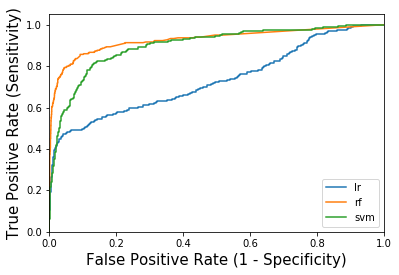

In [23]:
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(train_class, y_pred_prob_lr[:,1])
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(train_class, y_pred_prob_rf[:,1])
fpr_svm, tpr_svm, thresholds_svm = metrics.roc_curve(train_class, y_pred_prob_svm[:,1])
# plot LR model ROC curves
plt.plot(fpr_lr, tpr_lr,label="lr")
plt.plot(fpr_rf, tpr_rf,label="rf")
plt.plot(fpr_svm, tpr_svm,label="svm")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize = 15)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize = 15)

Text(0, 0.5, 'Precision')

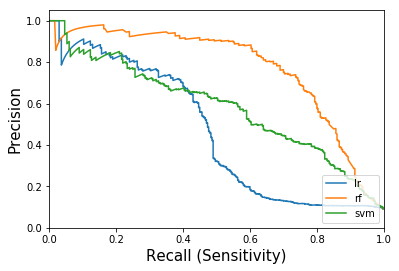

In [24]:
# calculate precision-recall curve
precision_lr, recall_lr, thresholds_pr_lr = metrics.precision_recall_curve(train_class, y_pred_prob_lr[:,1])
precision_rf, recall_rf, thresholds_pr_rf = metrics.precision_recall_curve(train_class, y_pred_prob_rf[:,1])
precision_svm, recall_svm, thresholds_pr_svm = metrics.precision_recall_curve(train_class, y_pred_prob_svm[:,1])

plt.plot(recall_lr, precision_lr, label='lr')
plt.plot(recall_rf, precision_rf, label='rf')
plt.plot(recall_svm, precision_svm, label='svm')

plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.xlabel('Recall (Sensitivity)', fontsize = 15)
plt.ylabel('Precision', fontsize = 15)

Text(0, 0.5, 'True Positive Rate (Sensitivity) or Class 1 Threshold Probability')

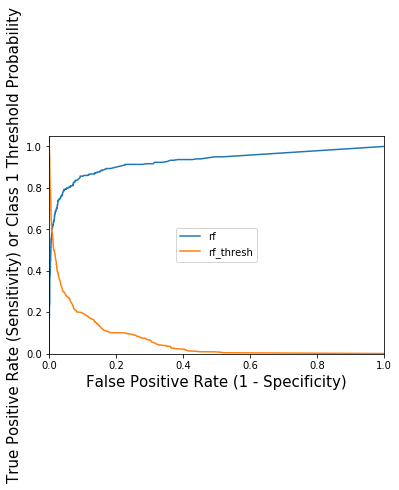

In [25]:
# plot best model with thresholds
plt.plot(fpr_rf, tpr_rf, label="rf")
plt.plot(fpr_rf, thresholds_rf, label="rf_thresh")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="center")
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize= 15)
plt.ylabel('True Positive Rate (Sensitivity) or Class 1 Threshold Probability', fontsize = 15)

In [39]:
#create new columns for each model's pred prob and the best model's pred class
train['pred_prob_lr'] = y_pred_prob_lr[:,1]
train['pred_prob_rf'] = y_pred_prob_rf[:,1]
train['pred_prob_svm'] = y_pred_prob_svm[:,1]
train['class_rf'] = y_pred_rf
train['class_svm'] = y_pred_svm
train.head()

,Unnamed: 0,animal_number,session,time_stamp,Annotation,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll,class,pred_prob_lr,pred_prob_rf,pred_prob_svm,class_rf,class_svm
27,27,624,CPApost,307800.0,bbc,541887.250,0.044343,11489.336861,19024.756765,5.615024,33.540626,-0.001363,10914.870018,1,0.562365,0.274717,0.040939,0,0
1731,1406,656,CPApost,573457.5,rand_noise,63754.562,0.443922,44443.494254,4349.336337,-0.642050,0.795118,0.000937,42221.319542,0,0.359241,0.000000,0.021891,0,0
673,570,553,neutral,281992.5,rand_noise,42222.527,0.358952,31811.537139,1594.206858,-0.291267,1.652326,0.000386,30220.960282,0,0.106098,0.000000,0.021562,0,0
1053,950,622,neutral,590377.5,rand_noise,84111.234,0.259125,37260.447227,59383.021912,4.324454,19.017546,-0.001053,35397.424866,0,0.451673,0.006149,0.012909,0,0
1017,692,535,CPApost,296122.5,rand_noise,55469.570,0.249859,32398.583089,23860.697690,5.331809,34.811206,-0.001154,30778.653935,0,0.570015,0.297229,0.122222,0,0


In [0]:
#create a predictions column for subesquent viz of TN, TP, FN, FP
def conf_mat_column(dataframe, model_name):
  preds = []
  for index, row in dataframe.iterrows():
      if (row['class'] == 0) & (row[model_name] == 0):
          pred = 'TN'
      if (row['class'] == 0) & (row[model_name] == 1):
          pred = 'FP'
      if (row['class'] == 1) & (row[model_name] == 1):
          pred = 'TP'
      if (row['class'] == 1) & (row[model_name] == 0):
          pred = 'FN'
          
      preds.append(pred)
      
  dataframe[str('pred_' + model_name)] = preds
  return dataframe

In [41]:
#create a predictions column for subesquent viz of TN, TP, FN, FP
model_name = 'class_rf'
train = conf_mat_column(train, model_name)
model_name = 'class_svm'
train = conf_mat_column(train, model_name)
train.head()

,Unnamed: 0,animal_number,session,time_stamp,Annotation,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll,class,pred_prob_lr,pred_prob_rf,pred_prob_svm,class_rf,class_svm,pred_class_rf,pred_class_svm
27,27,624,CPApost,307800.0,bbc,541887.250,0.044343,11489.336861,19024.756765,5.615024,33.540626,-0.001363,10914.870018,1,0.562365,0.274717,0.040939,0,0,FN,FN
1731,1406,656,CPApost,573457.5,rand_noise,63754.562,0.443922,44443.494254,4349.336337,-0.642050,0.795118,0.000937,42221.319542,0,0.359241,0.000000,0.021891,0,0,TN,TN
673,570,553,neutral,281992.5,rand_noise,42222.527,0.358952,31811.537139,1594.206858,-0.291267,1.652326,0.000386,30220.960282,0,0.106098,0.000000,0.021562,0,0,TN,TN
1053,950,622,neutral,590377.5,rand_noise,84111.234,0.259125,37260.447227,59383.021912,4.324454,19.017546,-0.001053,35397.424866,0,0.451673,0.006149,0.012909,0,0,TN,TN
1017,692,535,CPApost,296122.5,rand_noise,55469.570,0.249859,32398.583089,23860.697690,5.331809,34.811206,-0.001154,30778.653935,0,0.570015,0.297229,0.122222,0,0,TN,TN


In [43]:
train.groupby('Annotation')['pred_class_svm'].value_counts()

Annotation   pred_class_svm
bbc          TP                  69
             FN                  29
high         TP                  24
             FN                  10
high multi   FN                   2
             TP                   2
low          TP                  75
             FN                  38
low complex  TP                  13
             FN                   3
low multi    TP                  30
             FN                   5
rand_noise   TN                2721
             FP                 287
Name: pred_class_svm, dtype: int64

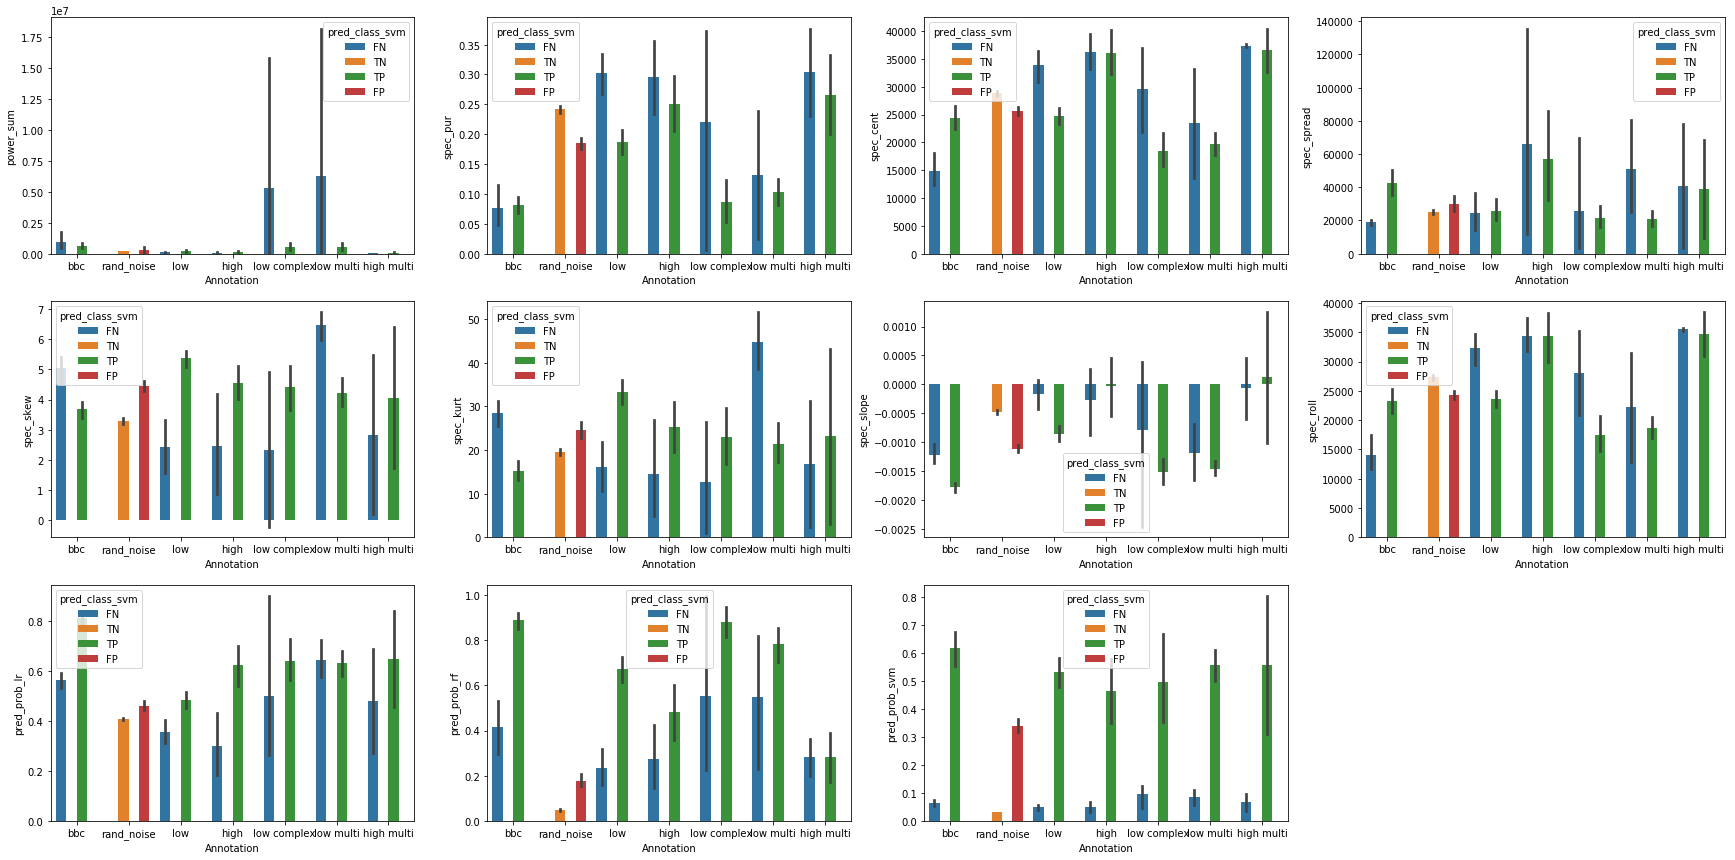

In [46]:
#viz of feature vs. pred group
feat_col = ['power_sum', 'spec_pur', 'spec_cent', 'spec_spread', 'spec_skew',
       'spec_kurt', 'spec_slope', 'spec_roll', 'pred_prob_lr', 'pred_prob_rf',
       'pred_prob_svm']

i=1
plt.figure(figsize=(30,20))
for name in feat_col:
    plt.subplot(4, 4, i)
    sns.barplot(x="Annotation", y=name, hue="pred_class_svm", data=train)
    i = i + 1

In [60]:
#viz for false negatives (need path for corresponding netcdf files)
netcdf_path = '/content/gdrive/Shared drives/USV_eScience_Incubator/Data/netcdf_files/CPA'
false_neg_unique = train_upsamples[train_upsamples['pred'] == 'FN'].drop_duplicates()
dim = dim = np.int(np.ceil(np.sqrt(false_neg_unique.shape[0])))
i = 1
plt.figure(figsize=(dim*5,dim*5))
for index, row in false_neg_unique.iterrows():
  data = xr.open_dataset(str(netcdf_path + '/' + row['animal_number'] + '_' + row['session'] + '_xr_Dataset.nc'))
    
  data_slice = data['__xarray_dataarray_variable__'].sel(slices=row['time_stamp'])
  times = data['times'].values
  freqs = data['freq'].values
    
  max_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).max(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
  #min_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).min(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    
  plt.subplot(dim, dim, i)
  xr.ufuncs.log(data_slice).plot(cmap='magma', vmin=0, vmax = max_value*.7)
    
  i = i + 1

TypeError: ignored

<Figure size 1080x1080 with 0 Axes>

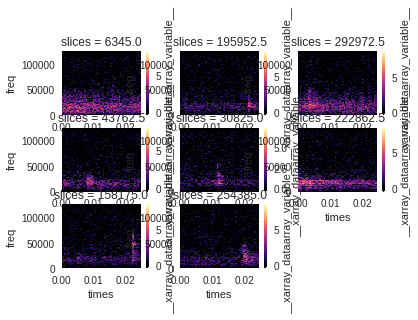

In [0]:
#viz for false positives (need path for corresponding netcdf files)
netcdf_path_pain = '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/netcdf_files/Pain'
false_pos_unique = train_upsamples[train_upsamples['pred'] == 'FP'].drop_duplicates()
dim = dim = np.int(np.ceil(np.sqrt(false_pos_unique.shape[0])))
i = 1
plt.figure(figsize=(dim*5,dim*5))
for index, row in false_pos_unique.iterrows():
    data = xr.open_dataset(str(netcdf_path_pain + '/' + row['session'] + '-' + row['animal_number'] + '-Pre_xr_Dataset.nc'))
    
    data_slice = data['__xarray_dataarray_variable__'].sel(slices=row['time_stamp'])
    times = data['times'].values
    freqs = data['freq'].values
    
    max_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).max(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    #min_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).min(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    
    plt.subplot(dim, dim, i)
    xr.ufuncs.log(data_slice).plot(cmap='magma', vmin=0, vmax = max_value*.7)
    
    i = i + 1

In [47]:
#once you have decided on the model and hyperparameters, fit the model using the train data
rf_cv.fit(train_features_scaled, train_class) 
svm_cv.fit(train_features_scaled, train_class) 

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [48]:
#test model using test data and theshold of 0.5
print(rf_cv.score(test_features_scaled, test_class))
test_pred_rf = rf_cv.predict(test_features_scaled)
test_pred_prob_rf = rf_cv.predict_proba(test_features_scaled)
print(classification_report(test_class, test_pred_rf))
confusion_matrix(test_class, test_pred_rf)

0.9132581100141044
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1290
           1       0.53      0.39      0.45       128

    accuracy                           0.91      1418
   macro avg       0.73      0.68      0.70      1418
weighted avg       0.90      0.91      0.91      1418



array([[1245,   45],
       [  78,   50]])

In [49]:
#test model using test data and theshold of 0.5
print(svm_cv.score(test_features_scaled, test_class))
test_pred_svm = svm_cv.predict(test_features_scaled)
test_pred_prob_svm = svm_cv.predict_proba(test_features_scaled)
print(classification_report(test_class, test_pred_svm))
confusion_matrix(test_class, test_pred_svm)

0.8427362482369535
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      1290
           1       0.34      0.80      0.48       128

    accuracy                           0.84      1418
   macro avg       0.66      0.83      0.69      1418
weighted avg       0.92      0.84      0.87      1418



array([[1092,  198],
       [  25,  103]])

In [50]:
#create new column for model pred porb
test['pred_prob_rf'] = test_pred_prob_rf[:,1]
test['class_rf'] = test_pred_rf
test['pred_prob_svm'] = test_pred_prob_svm[:,1]
test['class_svm'] = test_pred_svm

#create a predictions column for subesquent viz of TN, TP, FN, FP
model_name = 'class_rf'
test = conf_mat_column(test, model_name)
model_name = 'class_svm'
test = conf_mat_column(test, model_name)
test.head()

,Unnamed: 0,animal_number,session,time_stamp,Annotation,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll,class,pred_prob_rf,class_rf,pred_prob_svm,class_svm,pred_class_rf,pred_class_svm
152,49,527,neutral,140242.5,rand_noise,38556.316,0.320022,29570.603639,1293.741856,-0.497560,1.284092,0.000065,28092.073457,0,0.128356,0,0.025797,0,TN,TN
2844,2519,627,CPApost,101610.0,rand_noise,779277.600,0.042572,11052.010068,20531.172093,5.649183,33.035580,-0.001311,10499.409565,0,0.100000,0,0.200813,1,TN,FP
1611,1286,621,CPApost,250582.5,rand_noise,692664.060,0.034936,10323.207374,16599.630992,5.067392,26.272333,-0.001297,9807.047006,0,0.000000,0,0.148780,1,TN,FP
339,14,625,CPApost,110520.0,rand_noise,506830.900,0.035953,10786.297348,19280.038884,5.504591,31.903544,-0.001349,10246.982481,0,0.300000,0,0.067757,0,TN,TN
65,65,535,CPApost,356287.5,low,35185.500,0.357261,37944.582480,5697.508074,1.392004,5.159233,0.000499,36047.353356,1,0.231694,0,0.103989,0,FN,FN


In [51]:
test.groupby('Annotation')['pred_class_svm'].value_counts()

Annotation   pred_class_svm
bbc          TP                  34
             FN                   8
high         TP                  11
             FN                   3
high multi   TP                   1
low          TP                  36
             FN                  13
low complex  TP                   6
             FN                   1
low multi    TP                  15
rand_noise   TN                1092
             FP                 198
Name: pred_class_svm, dtype: int64

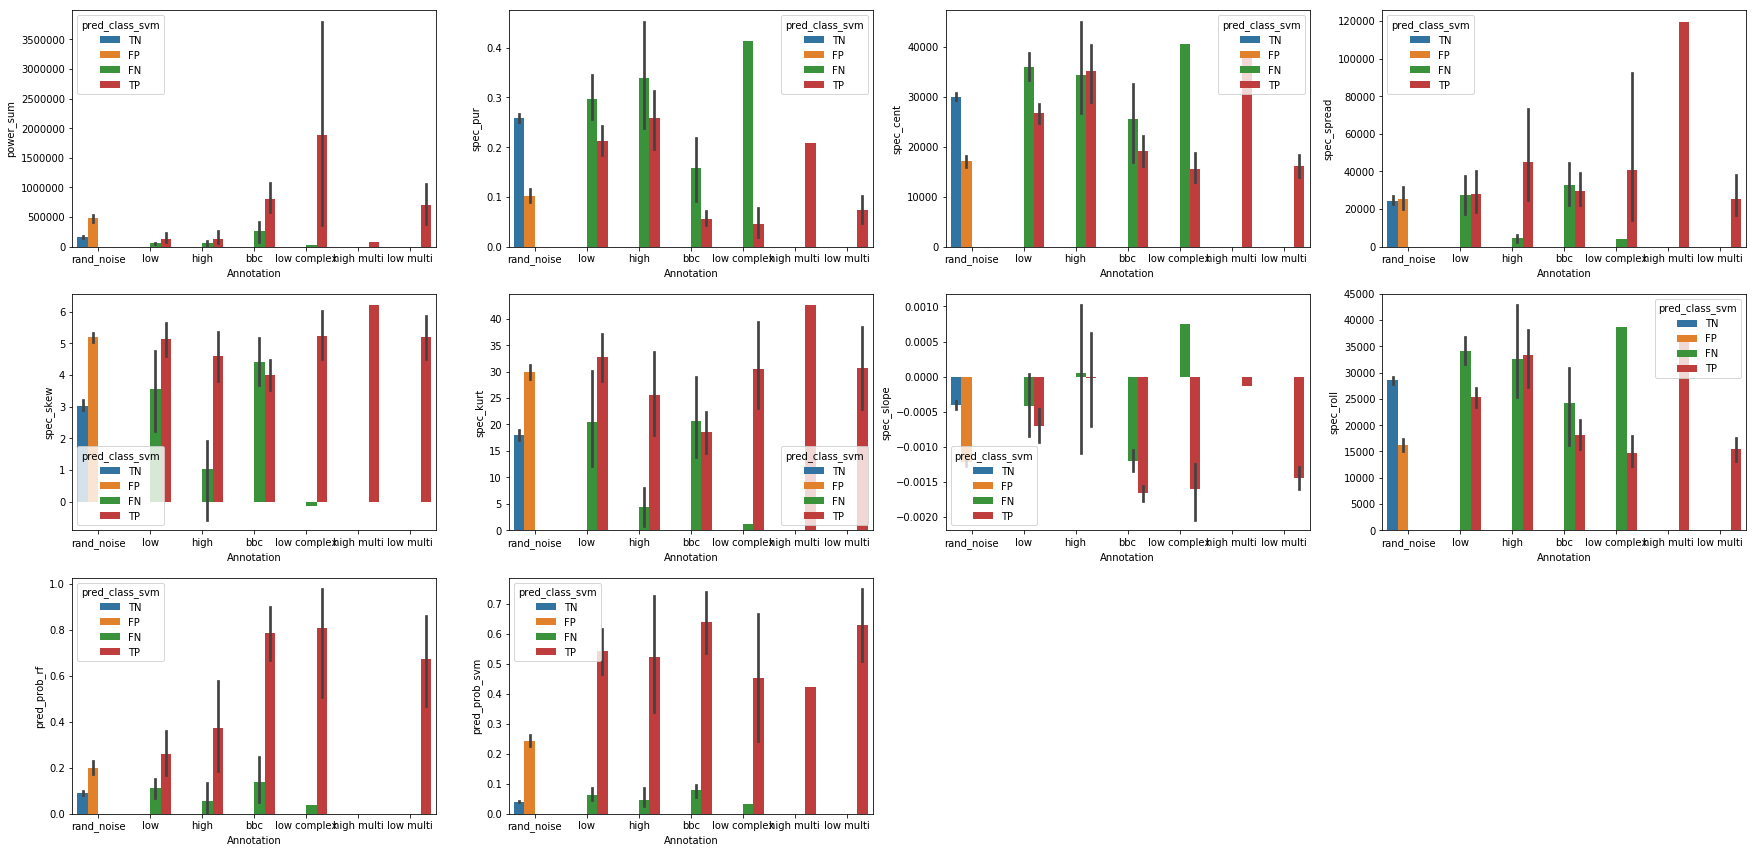

In [54]:
#viz of feature vs. pred group
feat_col = ['power_sum', 'spec_pur', 'spec_cent', 'spec_spread', 'spec_skew',
       'spec_kurt', 'spec_slope', 'spec_roll', 'pred_prob_rf',
       'pred_prob_svm']

i=1
plt.figure(figsize=(30,20))
for name in feat_col:
    plt.subplot(4, 4, i)
    sns.barplot(x="Annotation", y=name, hue="pred_class_svm", data=test)
    i = i + 1

In [0]:
#pickel model to save for later use
save_path = '/content/gdrive/Shared drives/USV_eScience_Incubator/Data/pickled_models/'


pkl_filename = str(save_path + "trained_pickle_model_8features_rf_strat_noup.pkl")  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(rf_cv, file)

In [0]:
#pickel model to save for later use
save_path = '/content/gdrive/Shared drives/USV_eScience_Incubator/Data/pickled_models/'


pkl_filename = str(save_path + "trained_pickle_model_8features_svm_strat_noup.pkl")  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(svm_cv, file)

In [57]:
%%time
# This function can take a long to run
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,  perplexity=50.0, n_iter=5000)
tsne_features = tsne.fit_transform(train_features_scaled)

CPU times: user 2min 22s, sys: 691 ms, total: 2min 22s
Wall time: 2min 22s


In [58]:
print(tsne_features.shape)
tsne_df = pd.DataFrame(data = tsne_features, columns = ['tsne_0', 'tsne_1'], index = train['Unnamed: 0'])
tsne_df['label'] = train['class'].values
tsne_df['session'] = train['session'].values
tsne_df['Annotation'] = train['Annotation'].values
tsne_df.head()

(3308, 2)


,tsne_0,tsne_1,label,session,Annotation
Unnamed: 0,,,,,
27,30.631256,51.991665,1,CPApost,bbc
1406,-1.516690,-83.177597,0,CPApost,rand_noise
570,47.871155,-20.179976,0,neutral,rand_noise
950,-61.252007,16.117752,0,neutral,rand_noise
692,-16.453604,-17.514700,0,CPApost,rand_noise


Text(0.5, 1.0, 'Projection of the data on 2 components + ground truth labels')

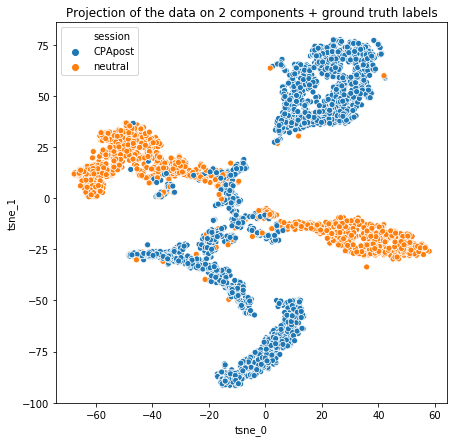

In [60]:
plt.figure(figsize=(7,7))
sns.scatterplot(x = 'tsne_0', y = 'tsne_1', hue = 'session', data = tsne_df)
plt.title("Projection of the data on 2 components + ground truth labels")